In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import pandas as pd
import numpy as np
import sys
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras import optimizers
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from scipy import signal
from scipy.io import wavfile
import cv2
import IPython.display as ipd
from os import listdir
from os.path import isfile, join
from glob import glob

Using TensorFlow backend.


# Data Preprocessing

In [3]:
def show(spectrogram):
    plt.imshow(spectrogram)
    plt.show()

In [42]:
#Image shape of the generated spectrograms
input_size = (224, 230)

def get_spec(files):
    path = 'path to files'
    os.chdir(path)
            
    N = len(files)
    data = np.zeros((N, input_size[0], input_size[1], 3))

    for i in range(0, len(files), 1):
        img = cv2.imread(files[i])
        data[i] = img
            
    return data

def shift_img(img, M):
    img = cv2.imread(files[0])
    rows, cols, _ = img.shape

    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

def fit_y(y):
    newy = []
    for i in range(len(y)):
        newy.append(y[i])
        newy.append(y[i])
        newy.append(y[i])
        newy.append(y[i])
    return np.array(newy)

def time_shift(wav):
    start_ = int(np.random.uniform(-4800,4800))
    if start_ >= 0:
        wav_time_shift = np.r_[wav[start_:], np.random.uniform(-0.001,0.001, start_)]
    else:
        wav_time_shift = np.r_[np.random.uniform(-0.001,0.001, -start_), wav[:start_]]
    return wav_time_shift

def speed_change(wav):
    speed_rate = np.random.uniform(0.7,1.3)
    wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()
    #print('speed rate: %.3f' % speed_rate, '(lower is faster)')
    if len(wav_speed_tune) < len(wav):
        pad_len = len(wav) - len(wav_speed_tune)
        wav_speed_tune = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                               wav_speed_tune,
                               np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
    else: 
        cut_len = len(wav_speed_tune) - len(wav)
        wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+len(wav)]
    return wav_speed_tune

In [43]:
#TRAIN MODE NOW
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip1, sample_rate = librosa.load(filename, sr=None)
    clip2 = time_shift(clip1)
    clip3 = speed_change(clip1)
    clip4 = speed_change(clip2)
    save_spec(clip1, sample_rate, name + "_0")
    save_spec(clip2, sample_rate, name + "_1")
    save_spec(clip3, sample_rate, name + "_2")
    save_spec(clip4, sample_rate, name + "_3")
    
def save_spec(clip, sample_rate, name):
    plt.interactive(False)
    
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = 'path to new folder' + name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

### Train spectogram creation

#### Create spectrograms from the wav files. Augmentation multiplies the file count by 4

In [ ]:
from os import listdir
from os.path import isfile, join
from glob import glob
mypath = "path to urban wav files"
dr = listdir(mypath)
for i in range(len(dr)):
    dr[i] = int(dr[i][:-4])
dr = np.sort(dr)
files = np.zeros(len(dr)).astype('str')
for i in range(len(dr)):
    files[i] = str(dr[i]) + '.wav'
files

In [ ]:
os.chdir('project directory')
y = pd.read_csv('train.csv')
y = y.values

In [ ]:
os.chdir('path to wave files')
for i in range(len(files)):
    create_spectrogram(files[i], str(y[i, 0]))

### Read spectrogram

In [ ]:
mypath = "path to folder with spectrograms"
dr = listdir(mypath)
for i in range(len(dr)):
    dr[i] = int(dr[i][:-6])
dr = np.sort(dr)
files = np.zeros(len(dr)).astype('str')
for i in range(0,len(dr),4):
    files[i] = str(dr[i]) + '_0.jpg'
    files[i+1] = str(dr[i+1]) + '_1.jpg'
    files[i+2] = str(dr[i+2]) + '_2.jpg'
    files[i+3] = str(dr[i+3]) + '_3.jpg'
files

In [ ]:
X = get_spec(files)

In [ ]:
X.nbytes / (2**10)**3

In [ ]:
os.chdir('project directory')
y_id = pd.read_csv("train.csv")
y_id = y_id.values[:, 1].astype('<U16')
y_id = fit_y(y_id)

In [ ]:
os.chdir('project directory')
channel = 3
lb = LabelBinarizer()
y = lb.fit_transform(y_id)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.33, random_state = 42)
X_train = X_train.astype ('float32')
X_test = X_test.astype ('float32')
X_val = X_val.astype ('float32')
X_train /= 255
X_test /= 255
X_val /= 255

X_train = X_train.reshape (-1, input_size[0], input_size[1], channel)
X_test = X_test.reshape (-1, input_size[0], input_size[1], channel)
X_val = X_val.reshape (-1, input_size[0], input_size[1], channel)

In [ ]:
show(X_train[8])

# Deep Learning Model

In [44]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size = 40, dim = input_size, n_channels = 3,
                 n_classes = 10, shuffle = True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # Generate data
        X = self.__data_generation(list_IDs_temp)
        
        y = self.labels[indexes]
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            image = cv2.imread('path to spectrograms' + ID)
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #X[i,] = gray.reshape((224,230,1))
            X[i,] = image
            X[i,] /= 255
            
        return X

In [47]:
# Initialising the CNN
n_labels = 10
model = Sequential()
chanDim = -1
channel = 3
#channel = 1 for grayscale

# Layer 1
model.add(Conv2D(32, (3, 3), padding = "same", input_shape = (input_size[0], input_size[1], channel)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(Conv2D(64, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(Conv2D(128, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))


# (CONV => RELU) * 2 => POOL
model.add(Conv2D(200, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(Conv2D(200, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
    
# Step 3 - Flattening
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_labels))
model.add(Activation("softmax"))

# Compiling the CNN
EPOCHS = 50
INIT_LR = 1e-3
opt = Adam(lr = INIT_LR, decay = INIT_LR / EPOCHS)
#opt = SGD(lr = 0.01, decay = 1e-8, momentum = 0.9, nesterov=True)
model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [8]:
os.chdir('project directory')
y_csv = pd.read_csv("train.csv")
l = y_csv.values[:, 1].astype('<U16')
l = fit_y(l)

In [9]:
lb = LabelBinarizer()
y = lb.fit_transform(l)
y

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [10]:
from os import listdir
from os.path import isfile, join
from glob import glob
mypath = "path to spectrogram files"
dr = listdir(mypath)
for i in range(len(dr)):
    dr[i] = int(dr[i][:-6])
dr = np.sort(dr)
files = np.zeros(len(dr)).astype('str')
for i in range(0,len(dr),4):
    files[i] = str(dr[i]) + '_0.jpg'
    files[i+1] = str(dr[i+1]) + '_1.jpg'
    files[i+2] = str(dr[i+2]) + '_2.jpg'
    files[i+3] = str(dr[i+3]) + '_3.jpg'
files

array(['0_0.jpg', '0_1.jpg', '0_2.jpg', ..., '8729_1.jpg', '8729_2.jpg',
       '8729_3.jpg'], dtype='<U32')

In [11]:
y_id = files

In [12]:
train_id, test_id, train_label, test_label = train_test_split(y_id, y, test_size = 0.33, random_state = 42)

In [13]:
training_generator = DataGenerator(train_id, train_label)
validation_generator = DataGenerator(test_id, test_label)

In [14]:
model_filename = 'cnnmodel.pkl' 
callbacks = [
    EarlyStopping(monitor='val_acc',
                  patience=10,
                  verbose=1,
                  mode='auto'),
    
    ModelCheckpoint(model_filename, monitor='val_acc',
                    verbose=1,
                    save_best_only=True,
                    mode='auto'),
]

In [15]:
History = model.fit_generator(generator = training_generator,
                                validation_data = validation_generator,
                                epochs = 50,
                                callbacks = callbacks,
                                verbose = 1,
                                shuffle = True)

Epoch 1/50
364/364 [==============================] - 87s 239ms/step - loss: 1.1452 - acc: 0.6411 - val_loss: 3.7233 - val_acc: 0.3990

Epoch 00001: val_acc improved from -inf to 0.39902, saving model to cnnmodel_initSize_gengray.pkl
Epoch 2/50
364/364 [==============================] - 79s 218ms/step - loss: 0.6591 - acc: 0.7861 - val_loss: 1.3699 - val_acc: 0.6753

Epoch 00002: val_acc improved from 0.39902 to 0.67528, saving model to cnnmodel_initSize_gengray.pkl
Epoch 3/50
364/364 [==============================] - 80s 219ms/step - loss: 0.4719 - acc: 0.8443 - val_loss: 1.1427 - val_acc: 0.7175

Epoch 00003: val_acc improved from 0.67528 to 0.71746, saving model to cnnmodel_initSize_gengray.pkl
Epoch 4/50
364/364 [==============================] - 79s 218ms/step - loss: 0.4476 - acc: 0.8520 - val_loss: 1.6281 - val_acc: 0.5786

Epoch 00004: val_acc did not improve from 0.71746
Epoch 5/50
364/364 [==============================] - 81s 224ms/step - loss: 0.2865 - acc: 0.9023 - val_lo

In [48]:
model.load_weights("model.h5")

In [ ]:
y_pred = np.round(model.predict(X_test))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [40]:
model.save_weights("model.h5")

In [26]:
print(History.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


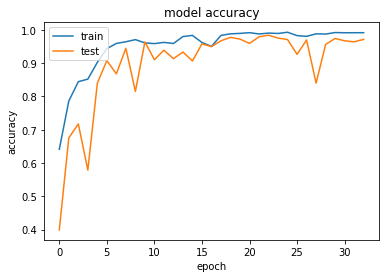

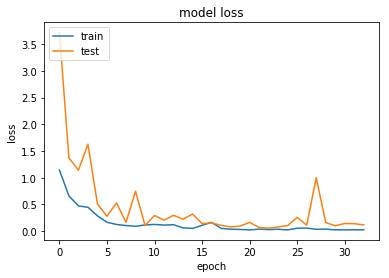

In [41]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()